In [1]:
!pip install dtaidistance numpy pandas matplotlib seaborn scipy scikit-learn tqdm
!pip install numba  
!pip install fastdtw  

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
# ## Step 2: Import Libraries

# %%
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Clustering and distance metrics
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import squareform
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# DTW specific
from dtaidistance import dtw
from dtaidistance import dtw_ndim

# For large datasets
import multiprocessing as mp
from functools import partial
import time

# Set style for better plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ All libraries imported successfully")
print(f"Number of CPU cores available: {mp.cpu_count()}")

✓ All libraries imported successfully
Number of CPU cores available: 8


Original series: [1 2 3 2 1 4 5 7 6 5]

Percentage changes: [  0.         100.          50.         -33.33333333 -50.
 300.          25.          40.         -14.28571429 -16.66666667]
Cumulative % changes: [  0.         100.         150.         116.66666667  66.66666667
 366.66666667 391.66666667 431.66666667 417.38095238 400.71428571]
Normalized (0-100): [  0.          23.16602317  34.74903475  27.02702703  15.44401544
  84.94208494  90.73359073 100.          96.69056812  92.82956426]
STARTING TRANSFORMATION PROCESS
Input file: DayByDay96_Volatility 10 Index.csv
Output file: transformed_cumulative_normalized.csv
Method: percentage
Normalize to 0-100: True

Loading data from: DayByDay96_Volatility 10 Index.csv
Loaded 3103 series with 96 time points each

Applying percentage transformation...


Transforming series: 100%|███████████████████████████████████████████████████████| 3103/3103 [00:00<00:00, 7424.89it/s]


✓ Transformed data saved to: transformed_cumulative_normalized.csv

TRANSFORMATION STATISTICS
Original data range: [5852.97, 11077.68]
Transformed data range: [0.00, 100.00]
Mean value - Original: 7358.27, Transformed: 50.12
Std dev - Original: 1294.24, Transformed: 26.48


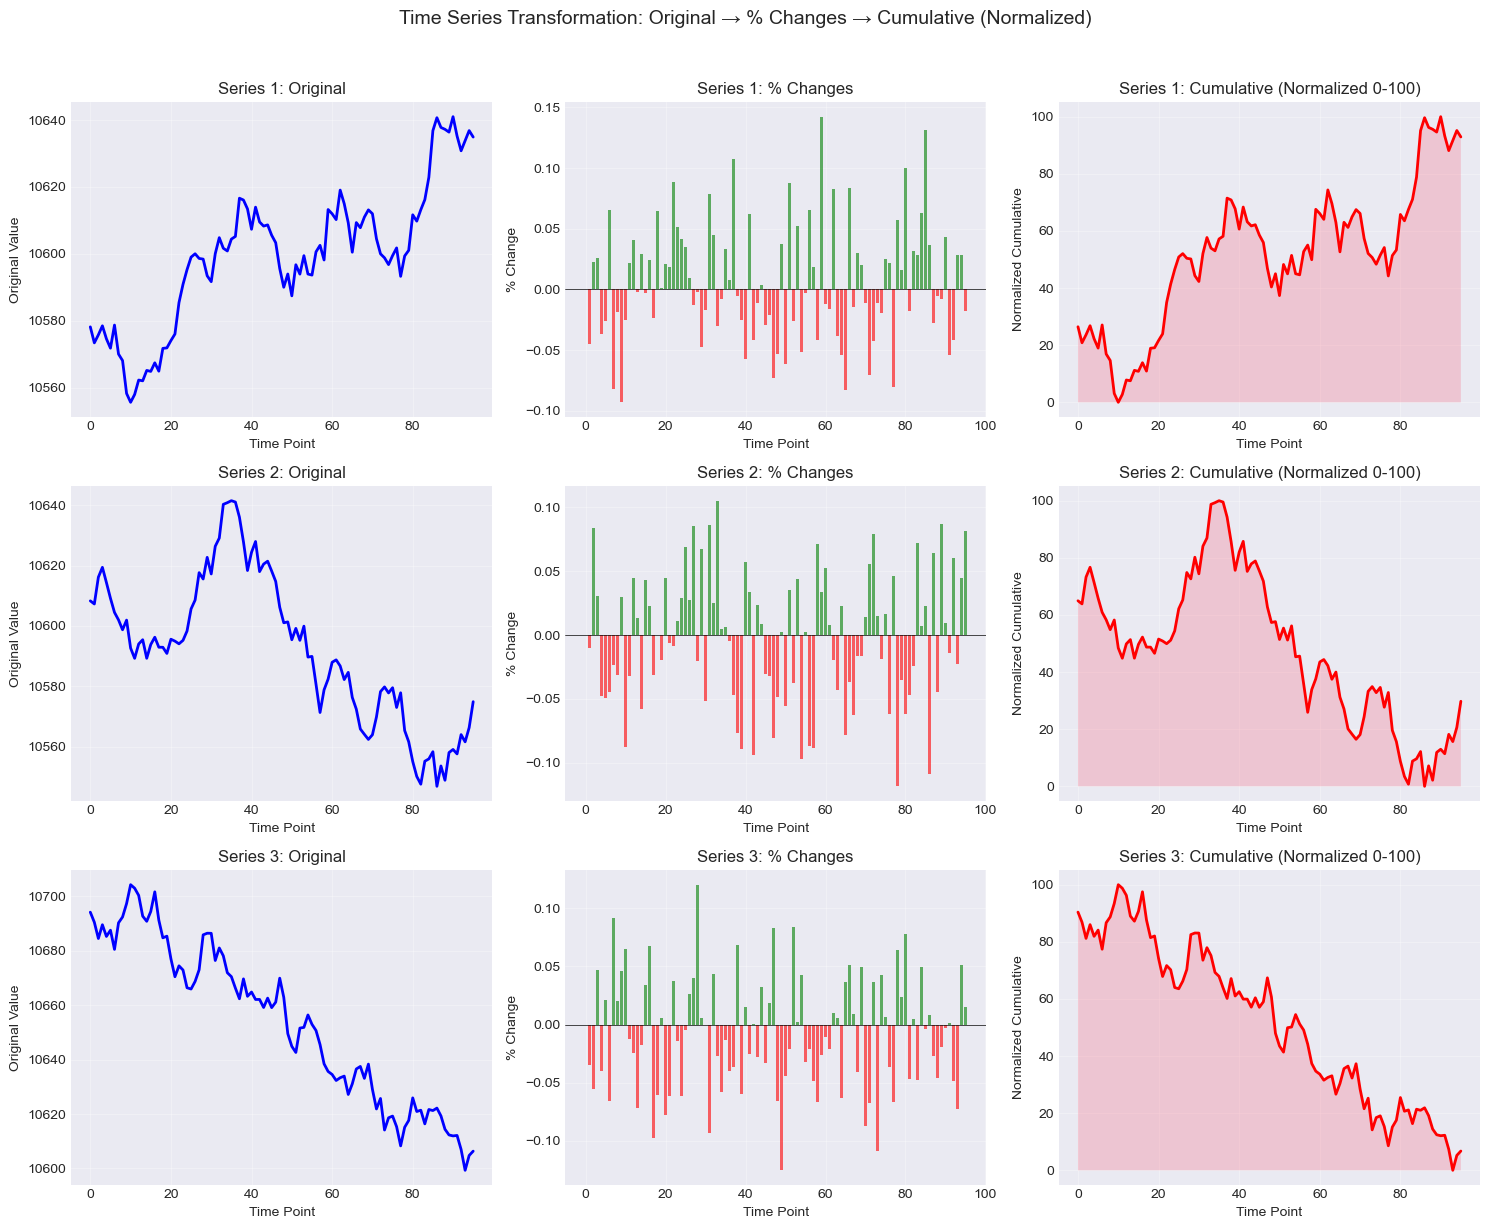


VERIFICATION OF SAVED FILE
Loaded transformed file: (3103, 96)
All values in [0, 100] range: True

Sample of transformed data (first 3 series, first 10 time points):
   10638.110  10631.070  10628.190  10621.786  10619.188  10611.001  \
0  26.447686  20.837631  23.645100  26.819064  22.248131  18.979964   
1  64.959453  63.864088  73.246308  76.681816  71.356198  65.864572   
2  90.395056  86.869577  81.201935  86.006748  81.921399  84.108106   

   10606.655  10607.089  10615.632  10618.086  
0  27.076264  16.915586  14.631813   3.101686  
1  60.924220  58.294606  54.838666  58.222794  
2  77.409546  86.683853  88.728771  93.420676  


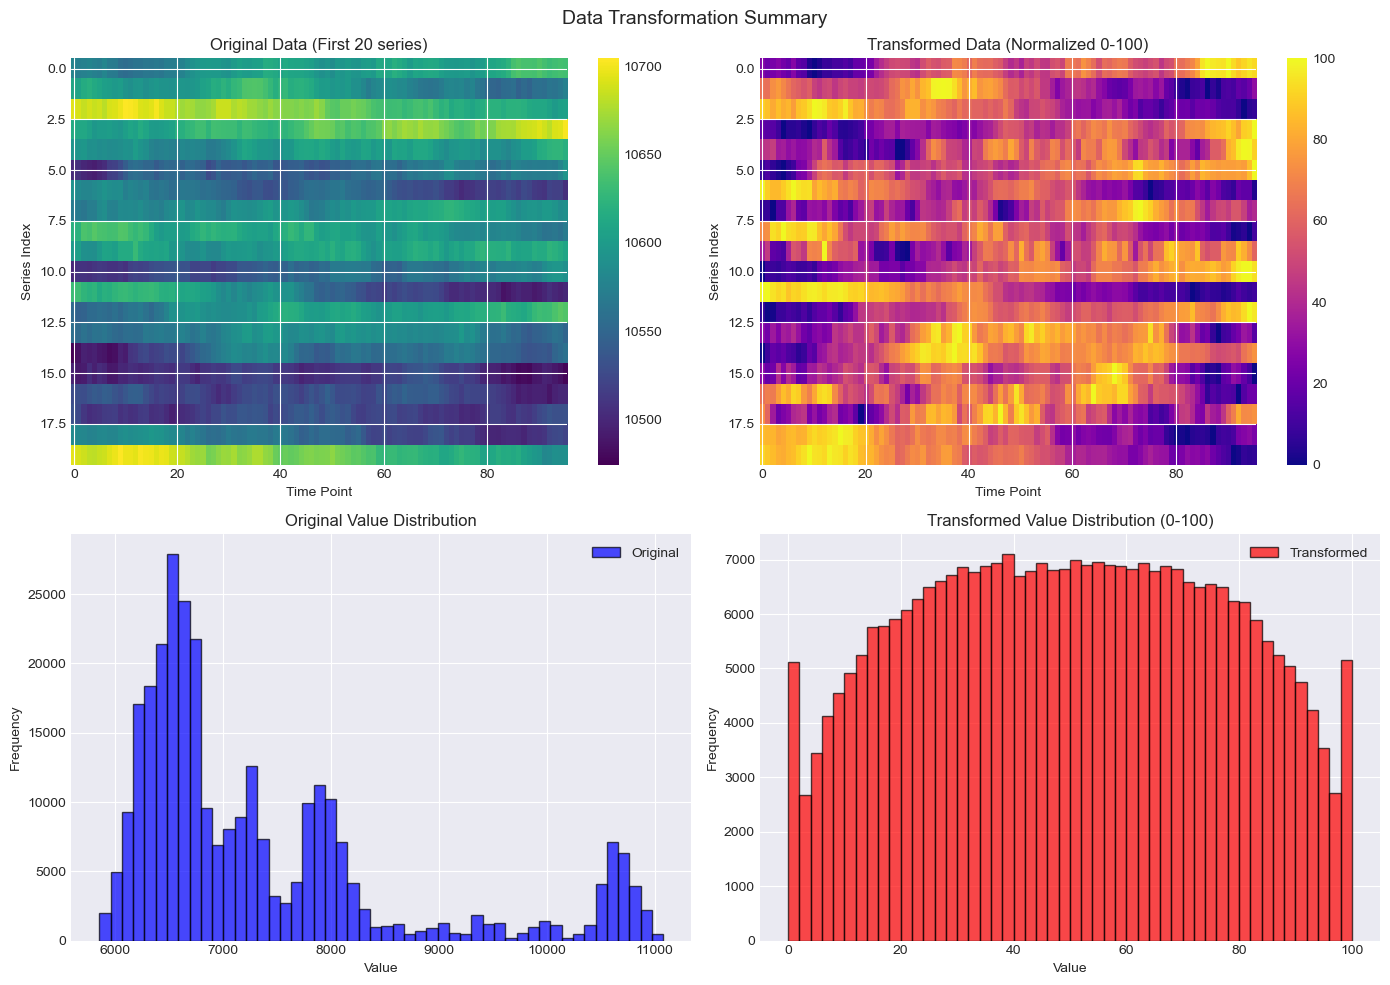


✓ Transformation complete! Your transformed data is saved in: transformed_cumulative_normalized.csv
You can now use this file as input for DTW clustering or other analyses.
Your example series: [1 2 3 2 1 4 5 7 6 5]

Transformation steps:
1. Percentage changes: [  0.   100.    50.   -33.33 -50.   300.    25.    40.   -14.29 -16.67]
2. Cumulative sum: [  0.   100.   150.   116.67  66.67 366.67 391.67 431.67 417.38 400.71]
3. Normalized (0-100): [  0.    23.17  34.75  27.03  15.44  84.94  90.73 100.    96.69  92.83]


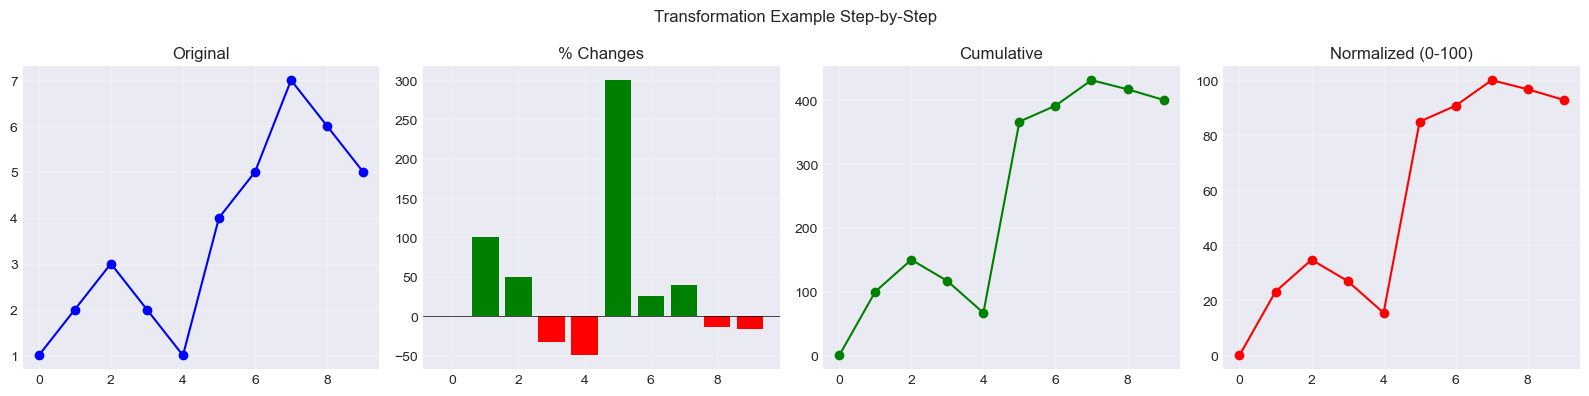

In [3]:
# %% [markdown]
# # Time Series Transformation: Cumulative Percentage Change
# ## Transform each series to cumulative % change and normalize to 0-100

# %%
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# %% [markdown]
# ## Understanding the Transformation
# 
# Let me demonstrate what I understand with a simple example:

# %%
# Example to clarify the transformation
example_series = np.array([1, 2, 3, 2, 1, 4, 5, 7, 6, 5])
print("Original series:", example_series)

# Method 1: Percentage change → Cumulative sum → Normalize
pct_changes = np.zeros(len(example_series))
pct_changes[0] = 0  # First value has no change
for i in range(1, len(example_series)):
    if example_series[i-1] != 0:
        pct_changes[i] = ((example_series[i] - example_series[i-1]) / example_series[i-1]) * 100
    else:
        pct_changes[i] = 0

print("\nPercentage changes:", pct_changes)

cumulative_pct = np.cumsum(pct_changes)
print("Cumulative % changes:", cumulative_pct)

# Normalize to 0-100
if cumulative_pct.max() - cumulative_pct.min() > 0:
    normalized = ((cumulative_pct - cumulative_pct.min()) / 
                  (cumulative_pct.max() - cumulative_pct.min())) * 100
else:
    normalized = cumulative_pct
print("Normalized (0-100):", normalized)

# %% [markdown]
# ## Main Transformation Functions

# %%
def calculate_percentage_changes(series):
    """
    Calculate percentage change between consecutive points
    """
    pct_changes = np.zeros(len(series))
    pct_changes[0] = 0  # No change for first point
    
    for i in range(1, len(series)):
        if series[i-1] != 0:
            pct_changes[i] = ((series[i] - series[i-1]) / series[i-1]) * 100
        else:
            # Handle division by zero
            if series[i] != 0:
                pct_changes[i] = 100  # Treat as 100% increase from 0
            else:
                pct_changes[i] = 0
    
    return pct_changes

def cumulative_transform(series, method='percentage'):
    """
    Transform a single time series to cumulative values
    
    Parameters:
    -----------
    series : array-like
        Input time series
    method : str
        'percentage' : Cumulative percentage changes
        'absolute' : Cumulative absolute changes
        'returns' : Cumulative returns (multiplicative)
    """
    if method == 'percentage':
        # Calculate percentage changes
        pct_changes = calculate_percentage_changes(series)
        # Calculate cumulative sum
        cumulative = np.cumsum(pct_changes)
        
    elif method == 'absolute':
        # Calculate absolute changes
        changes = np.zeros(len(series))
        changes[0] = 0
        changes[1:] = np.diff(series)
        # Calculate cumulative sum
        cumulative = np.cumsum(changes)
        
    elif method == 'returns':
        # Calculate returns (1 + r)
        returns = np.ones(len(series))
        returns[0] = 1
        for i in range(1, len(series)):
            if series[i-1] != 0:
                returns[i] = series[i] / series[i-1]
            else:
                returns[i] = 1
        # Calculate cumulative product
        cumulative = np.cumprod(returns)
        cumulative = (cumulative - 1) * 100  # Convert to percentage
    
    return cumulative

def normalize_to_range(series, min_val=0, max_val=100):
    """
    Normalize series to specified range [min_val, max_val]
    """
    series_min = np.min(series)
    series_max = np.max(series)
    
    if series_max - series_min > 0:
        normalized = ((series - series_min) / (series_max - series_min)) * (max_val - min_val) + min_val
    else:
        # If all values are the same, return middle of range
        normalized = np.full_like(series, (max_val + min_val) / 2)
    
    return normalized

# %% [markdown]
# ## Complete Transformation Pipeline

# %%
def transform_time_series_file(input_filepath, output_filepath, 
                              method='percentage', 
                              normalize=True,
                              show_examples=True):
    """
    Transform all time series in a CSV file
    
    Parameters:
    -----------
    input_filepath : str
        Path to input CSV file
    output_filepath : str
        Path to save transformed data
    method : str
        Transformation method ('percentage', 'absolute', 'returns')
    normalize : bool
        Whether to normalize to 0-100 range
    show_examples : bool
        Whether to display example transformations
    """
    
    # Load data
    print(f"Loading data from: {input_filepath}")
    df = pd.read_csv(input_filepath)
    print(f"Loaded {df.shape[0]} series with {df.shape[1]} time points each")
    
    # Prepare output array
    transformed_data = np.zeros_like(df.values)
    
    # Transform each series
    print(f"\nApplying {method} transformation...")
    for i in tqdm(range(len(df)), desc="Transforming series"):
        series = df.iloc[i].values
        
        # Apply cumulative transformation
        cumulative = cumulative_transform(series, method=method)
        
        # Normalize if requested
        if normalize:
            cumulative = normalize_to_range(cumulative, 0, 100)
        
        transformed_data[i] = cumulative
    
    # Create output dataframe
    output_df = pd.DataFrame(transformed_data, columns=df.columns)
    
    # Save to file
    output_df.to_csv(output_filepath, index=False)
    print(f"✓ Transformed data saved to: {output_filepath}")
    
    # Show statistics
    print("\n" + "="*60)
    print("TRANSFORMATION STATISTICS")
    print("="*60)
    print(f"Original data range: [{df.values.min():.2f}, {df.values.max():.2f}]")
    print(f"Transformed data range: [{transformed_data.min():.2f}, {transformed_data.max():.2f}]")
    print(f"Mean value - Original: {df.values.mean():.2f}, Transformed: {transformed_data.mean():.2f}")
    print(f"Std dev - Original: {df.values.std():.2f}, Transformed: {transformed_data.std():.2f}")
    
    # Show examples if requested
    if show_examples and len(df) > 0:
        visualize_transformation(df, output_df, n_examples=min(3, len(df)))
    
    return output_df

# %% [markdown]
# ## Visualization Function

# %%
def visualize_transformation(original_df, transformed_df, n_examples=3):
    """
    Visualize the transformation with examples
    """
    n_series = min(n_examples, len(original_df))
    
    fig, axes = plt.subplots(n_series, 3, figsize=(15, 4*n_series))
    if n_series == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(n_series):
        original = original_df.iloc[i].values
        transformed = transformed_df.iloc[i].values
        
        # Original series
        axes[i, 0].plot(original, 'b-', linewidth=2)
        axes[i, 0].set_title(f'Series {i+1}: Original')
        axes[i, 0].set_xlabel('Time Point')
        axes[i, 0].set_ylabel('Original Value')
        axes[i, 0].grid(True, alpha=0.3)
        
        # Percentage changes
        pct_changes = calculate_percentage_changes(original)
        axes[i, 1].bar(range(len(pct_changes)), pct_changes, 
                      color=['g' if x >= 0 else 'r' for x in pct_changes],
                      alpha=0.6)
        axes[i, 1].set_title(f'Series {i+1}: % Changes')
        axes[i, 1].set_xlabel('Time Point')
        axes[i, 1].set_ylabel('% Change')
        axes[i, 1].grid(True, alpha=0.3)
        axes[i, 1].axhline(y=0, color='k', linestyle='-', linewidth=0.5)
        
        # Transformed (cumulative & normalized)
        axes[i, 2].plot(transformed, 'r-', linewidth=2)
        axes[i, 2].set_title(f'Series {i+1}: Cumulative (Normalized 0-100)')
        axes[i, 2].set_xlabel('Time Point')
        axes[i, 2].set_ylabel('Normalized Cumulative')
        axes[i, 2].set_ylim(-5, 105)
        axes[i, 2].grid(True, alpha=0.3)
        axes[i, 2].fill_between(range(len(transformed)), 0, transformed, alpha=0.3)
    
    plt.suptitle('Time Series Transformation: Original → % Changes → Cumulative (Normalized)', 
                 fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

# %% [markdown]
# ## Alternative Interpretation: Direct Value Mapping
# 
# If you meant a different transformation (like value-based scaling), here's an alternative:

# %%
def alternative_transform(series, base_multiplier=100):
    """
    Alternative transformation: Direct value mapping
    This might be what you meant based on your example
    """
    # Method 1: Scale relative to first value
    if series[0] != 0:
        scaled = ((series - series[0]) / series[0]) * base_multiplier
    else:
        scaled = series * base_multiplier
    
    # Method 2: Direct scaling
    # scaled = (series - 1) * base_multiplier  # If your base is 1
    
    # Method 3: Cumulative sum of scaled differences
    # differences = np.zeros(len(series))
    # differences[1:] = np.diff(series)
    # cumulative = np.cumsum(differences * base_multiplier)
    
    return scaled

# %% [markdown]
# ## Main Execution: Run Your Transformation

# %%
# === MAIN EXECUTION ===
# Modify these parameters as needed

INPUT_FILE = "DayByDay96_Volatility 10 Index.csv"  # Your input file
OUTPUT_FILE = "transformed_cumulative_normalized.csv"  # Output file name

# Choose transformation method:
# - 'percentage': Cumulative percentage changes (recommended for volatility data)
# - 'absolute': Cumulative absolute changes
# - 'returns': Cumulative returns (multiplicative)
TRANSFORMATION_METHOD = 'percentage'

# Run the transformation
print("="*60)
print("STARTING TRANSFORMATION PROCESS")
print("="*60)
print(f"Input file: {INPUT_FILE}")
print(f"Output file: {OUTPUT_FILE}")
print(f"Method: {TRANSFORMATION_METHOD}")
print(f"Normalize to 0-100: True")
print("="*60 + "\n")

# Execute transformation
transformed_df = transform_time_series_file(
    input_filepath=INPUT_FILE,
    output_filepath=OUTPUT_FILE,
    method=TRANSFORMATION_METHOD,
    normalize=True,
    show_examples=True
)

# %% [markdown]
# ## Verify the Transformation

# %%
# Load and verify the saved file
print("\n" + "="*60)
print("VERIFICATION OF SAVED FILE")
print("="*60)

# Load the transformed data
saved_df = pd.read_csv(OUTPUT_FILE)
print(f"Loaded transformed file: {saved_df.shape}")
print(f"All values in [0, 100] range: {(saved_df.values.min() >= 0) and (saved_df.values.max() <= 100)}")

# Show sample of transformed data
print("\nSample of transformed data (first 3 series, first 10 time points):")
print(saved_df.iloc[:3, :10])

# %% [markdown]
# ## Quick Comparison: Before and After

# %%
# Create a comparison plot
original_df = pd.read_csv(INPUT_FILE)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Original data heatmap
im1 = axes[0, 0].imshow(original_df.values[:min(20, len(original_df))], 
                        aspect='auto', cmap='viridis')
axes[0, 0].set_title('Original Data (First 20 series)')
axes[0, 0].set_xlabel('Time Point')
axes[0, 0].set_ylabel('Series Index')
plt.colorbar(im1, ax=axes[0, 0])

# Transformed data heatmap
im2 = axes[0, 1].imshow(saved_df.values[:min(20, len(saved_df))], 
                        aspect='auto', cmap='plasma', vmin=0, vmax=100)
axes[0, 1].set_title('Transformed Data (Normalized 0-100)')
axes[0, 1].set_xlabel('Time Point')
axes[0, 1].set_ylabel('Series Index')
plt.colorbar(im2, ax=axes[0, 1])

# Distribution comparison
axes[1, 0].hist(original_df.values.flatten(), bins=50, alpha=0.7, 
                label='Original', color='blue', edgecolor='black')
axes[1, 0].set_title('Original Value Distribution')
axes[1, 0].set_xlabel('Value')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()

axes[1, 1].hist(saved_df.values.flatten(), bins=50, alpha=0.7, 
                label='Transformed', color='red', edgecolor='black')
axes[1, 1].set_title('Transformed Value Distribution (0-100)')
axes[1, 1].set_xlabel('Value')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_xlim(-5, 105)
axes[1, 1].legend()

plt.suptitle('Data Transformation Summary', fontsize=14)
plt.tight_layout()
plt.show()

print("\n✓ Transformation complete! Your transformed data is saved in:", OUTPUT_FILE)
print("You can now use this file as input for DTW clustering or other analyses.")

# %% [markdown]
# ## Custom Testing Section
# Test with your own example to verify the transformation is correct:

# %%
# Test with your specific example
test_series = np.array([1, 2, 3, 2, 1, 4, 5, 7, 6, 5])
print("Your example series:", test_series)

# Apply transformation
pct_changes = calculate_percentage_changes(test_series)
cumulative = np.cumsum(pct_changes)
normalized = normalize_to_range(cumulative, 0, 100)

print("\nTransformation steps:")
print("1. Percentage changes:", np.round(pct_changes, 2))
print("2. Cumulative sum:", np.round(cumulative, 2))
print("3. Normalized (0-100):", np.round(normalized, 2))

# Visualize
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

axes[0].plot(test_series, 'bo-')
axes[0].set_title('Original')
axes[0].grid(True, alpha=0.3)

axes[1].bar(range(len(pct_changes)), pct_changes, 
           color=['g' if x >= 0 else 'r' for x in pct_changes])
axes[1].set_title('% Changes')
axes[1].axhline(y=0, color='k', linestyle='-', linewidth=0.5)
axes[1].grid(True, alpha=0.3)

axes[2].plot(cumulative, 'go-')
axes[2].set_title('Cumulative')
axes[2].grid(True, alpha=0.3)

axes[3].plot(normalized, 'ro-')
axes[3].set_title('Normalized (0-100)')
axes[3].set_ylim(-5, 105)
axes[3].grid(True, alpha=0.3)

plt.suptitle('Transformation Example Step-by-Step')
plt.tight_layout()
plt.show()

DATASET INFORMATION
Shape: (3103, 96)
Number of time series: 3103
Length of each series: 96
Total data points: 297,888
Memory usage: 2.27 MB

Missing values: 0

STATISTICAL SUMMARY (first 5 time points)
          10638.110     10631.070     10628.190     10621.786     10619.188
count   3103.000000   3103.000000   3103.000000   3103.000000   3103.000000
mean    7357.541127   7357.463419   7357.436807   7357.355979   7357.287585
std     1293.959982   1293.912326   1293.997346   1294.112611   1294.078515
min     5865.754000   5867.658000   5869.044000   5869.926000   5867.695000
25%     6485.579500   6483.435500   6482.870000   6482.513000   6483.281500
50%     6807.732000   6805.254000   6807.559000   6805.120000   6807.889000
75%     7861.483000   7864.321000   7863.952500   7863.855500   7862.797500
max    11020.633000  11018.133000  11025.162000  11027.263000  11028.308000


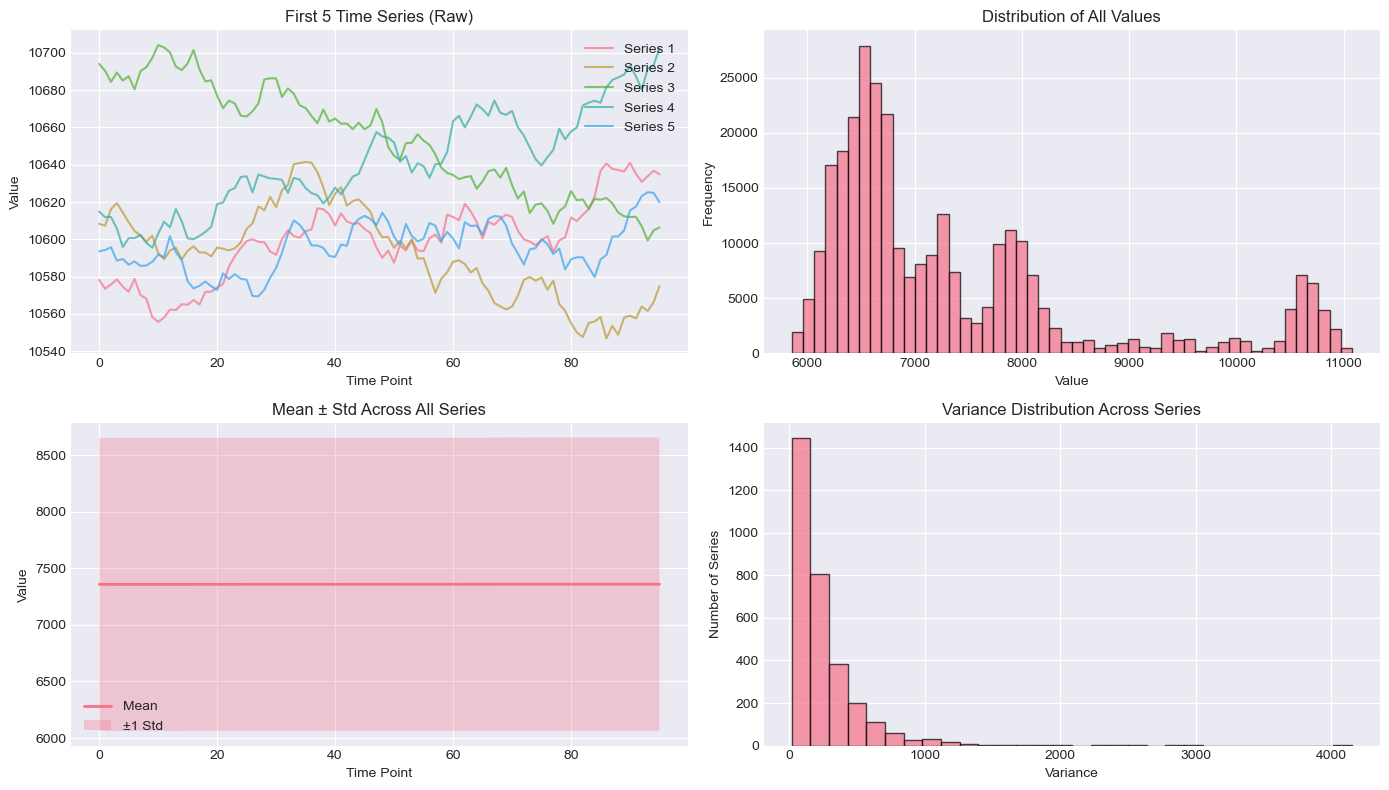

In [12]:
# ## Step 3: Load and Explore Your Data

# %%
def load_and_explore_data(filepath):
    """
    Load time series data and provide basic statistics
    """
    # Load data
    df = pd.read_csv(filepath)
    
    # Basic info
    print("="*60)
    print("DATASET INFORMATION")
    print("="*60)
    print(f"Shape: {df.shape}")
    print(f"Number of time series: {df.shape[0]}")
    print(f"Length of each series: {df.shape[1]}")
    print(f"Total data points: {df.shape[0] * df.shape[1]:,}")
    print(f"Memory usage: {df.memory_usage().sum() / 1024**2:.2f} MB")
    
    # Check for missing values
    missing = df.isnull().sum().sum()
    print(f"\nMissing values: {missing}")
    
    # Statistical summary
    print("\n" + "="*60)
    print("STATISTICAL SUMMARY (first 5 time points)")
    print("="*60)
    print(df.iloc[:, :5].describe())
    
    # Convert to numpy array for processing
    data_array = df.values
    
    # Visualize sample series
    fig, axes = plt.subplots(2, 2, figsize=(14, 8))
    
    # Plot first few series
    n_sample = min(5, len(data_array))
    axes[0, 0].set_title(f'First {n_sample} Time Series (Raw)')
    for i in range(n_sample):
        axes[0, 0].plot(data_array[i], alpha=0.7, label=f'Series {i+1}')
    axes[0, 0].legend()
    axes[0, 0].set_xlabel('Time Point')
    axes[0, 0].set_ylabel('Value')
    
    # Distribution of values
    axes[0, 1].set_title('Distribution of All Values')
    axes[0, 1].hist(data_array.flatten(), bins=50, edgecolor='black', alpha=0.7)
    axes[0, 1].set_xlabel('Value')
    axes[0, 1].set_ylabel('Frequency')
    
    # Mean and std across time
    means = np.mean(data_array, axis=0)
    stds = np.std(data_array, axis=0)
    axes[1, 0].set_title('Mean ± Std Across All Series')
    axes[1, 0].plot(means, label='Mean', linewidth=2)
    axes[1, 0].fill_between(range(len(means)), 
                            means - stds, means + stds, 
                            alpha=0.3, label='±1 Std')
    axes[1, 0].legend()
    axes[1, 0].set_xlabel('Time Point')
    axes[1, 0].set_ylabel('Value')
    
    # Variance across series
    variances = np.var(data_array, axis=1)
    axes[1, 1].set_title('Variance Distribution Across Series')
    axes[1, 1].hist(variances, bins=30, edgecolor='black', alpha=0.7)
    axes[1, 1].set_xlabel('Variance')
    axes[1, 1].set_ylabel('Number of Series')
    
    plt.tight_layout()
    plt.show()
    
    return df, data_array

# Load your data
filepath = "DayByDay96_Volatility 10 Index.csv"  # Change this to your file
df, data = load_and_explore_data(filepath)

Preprocessing 3103 time series...


Normalizing: 100%|███████████████████████████████████████████████████████████████| 3103/3103 [00:00<00:00, 6094.85it/s]


✓ Preprocessing complete


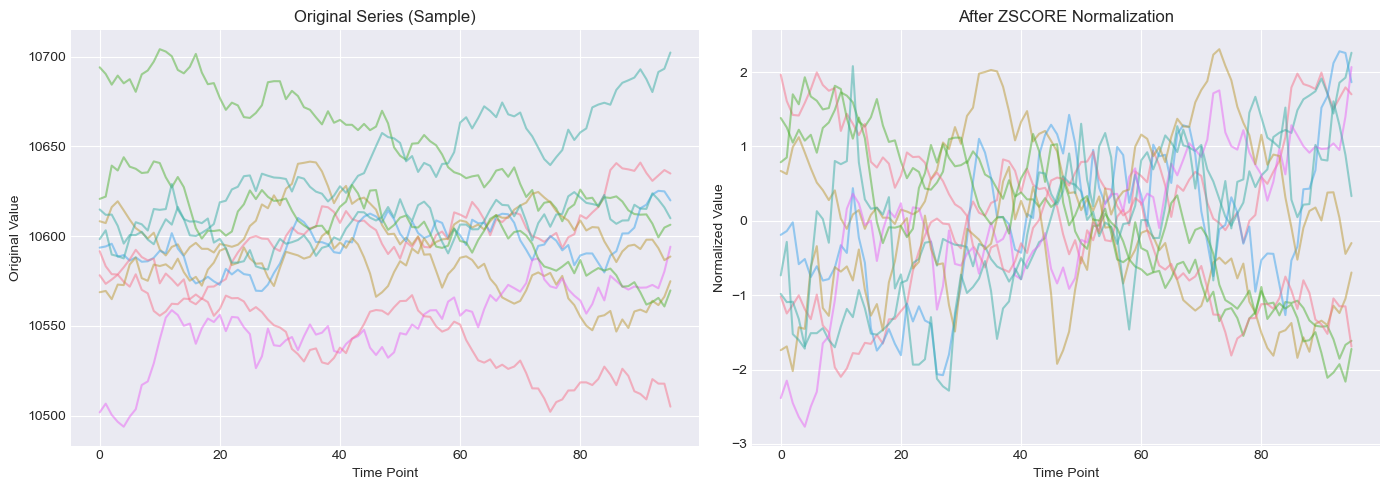

In [13]:
# ## Step 4: Data Preprocessing and Normalization

# %%
def preprocess_time_series(data, method='zscore', handle_outliers=True):
    """
    Preprocess time series data with various normalization options
    
    Parameters:
    -----------
    data : numpy array
        Each row is a time series
    method : str
        'zscore': Z-score normalization (mean=0, std=1)
        'minmax': Min-max scaling to [0,1]
        'robust': Robust scaling using median and IQR
    handle_outliers : bool
        If True, clip extreme outliers
    """
    n_series = len(data)
    processed = np.zeros_like(data)
    
    print(f"Preprocessing {n_series} time series...")
    
    for i in tqdm(range(n_series), desc="Normalizing"):
        series = data[i].copy()
        
        # Handle outliers if requested
        if handle_outliers:
            q1, q3 = np.percentile(series, [25, 75])
            iqr = q3 - q1
            lower = q1 - 3 * iqr
            upper = q3 + 3 * iqr
            series = np.clip(series, lower, upper)
        
        # Apply normalization
        if method == 'zscore':
            mean = np.mean(series)
            std = np.std(series)
            if std > 0:
                processed[i] = (series - mean) / std
            else:
                processed[i] = series - mean
                
        elif method == 'minmax':
            min_val = np.min(series)
            max_val = np.max(series)
            if max_val > min_val:
                processed[i] = (series - min_val) / (max_val - min_val)
            else:
                processed[i] = series - min_val
                
        elif method == 'robust':
            median = np.median(series)
            q1, q3 = np.percentile(series, [25, 75])
            iqr = q3 - q1
            if iqr > 0:
                processed[i] = (series - median) / iqr
            else:
                processed[i] = series - median
    
    print("✓ Preprocessing complete")
    
    # Visualize normalization effect
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Sample series before and after
    n_show = min(10, n_series)
    
    axes[0].set_title('Original Series (Sample)')
    for i in range(n_show):
        axes[0].plot(data[i], alpha=0.5)
    axes[0].set_xlabel('Time Point')
    axes[0].set_ylabel('Original Value')
    
    axes[1].set_title(f'After {method.upper()} Normalization')
    for i in range(n_show):
        axes[1].plot(processed[i], alpha=0.5)
    axes[1].set_xlabel('Time Point')
    axes[1].set_ylabel('Normalized Value')
    
    plt.tight_layout()
    plt.show()
    
    return processed

# Preprocess your data
normalized_data = preprocess_time_series(data, method='zscore', handle_outliers=True)

In [14]:
# ## Step 5: Efficient DTW Distance Computation for Large Datasets
# ### Using parallel processing and optimization techniques

# %%
def compute_dtw_distance_batch(indices, data, window, use_prunning):
    """
    Compute DTW distances for a batch of index pairs
    """
    distances = []
    for i, j in indices:
        if window:
            dist = dtw.distance_fast(data[i], data[j], window=window, use_pruning=use_prunning)
        else:
            dist = dtw.distance_fast(data[i], data[j], use_pruning=use_prunning)
        distances.append((i, j, dist))
    return distances

def compute_dtw_matrix_parallel(data, window_ratio=0.1, n_jobs=-1, sample_size=None):
    """
    Compute DTW distance matrix with parallel processing
    
    Parameters:
    -----------
    data : numpy array
        Normalized time series data
    window_ratio : float
        Sakoe-Chiba window as ratio of series length (0.1 = 10%)
    n_jobs : int
        Number of parallel jobs (-1 for all cores)
    sample_size : int or None
        If provided, randomly sample this many series for faster computation
    """
    # Sample if requested
    if sample_size and sample_size < len(data):
        print(f"Sampling {sample_size} series from {len(data)} total...")
        indices = np.random.choice(len(data), sample_size, replace=False)
        data = data[indices]
    
    n_series = len(data)
    series_length = data.shape[1]
    
    # Calculate window size
    window = int(window_ratio * series_length) if window_ratio else None
    
    print(f"Computing DTW distances for {n_series} series...")
    print(f"Series length: {series_length}")
    print(f"Window size: {window if window else 'No constraint'}")
    print(f"Total comparisons: {n_series * (n_series - 1) // 2:,}")
    
    # For very large datasets, use lower triangular computation
    distance_matrix = np.zeros((n_series, n_series))
    
    # Generate all pairs to compute
    pairs = [(i, j) for i in range(n_series) for j in range(i + 1, n_series)]
    
    # Compute distances with progress bar
    start_time = time.time()
    
    if n_series < 100:  # Small dataset - simple loop
        for i, j in tqdm(pairs, desc="Computing DTW"):
            dist = dtw.distance_fast(data[i], data[j], 
                                    window=window, 
                                    use_pruning=True)
            distance_matrix[i, j] = dist
            distance_matrix[j, i] = dist
            
    else:  # Large dataset - use batching
        batch_size = 1000
        for batch_start in tqdm(range(0, len(pairs), batch_size), 
                                desc="DTW Batches"):
            batch_end = min(batch_start + batch_size, len(pairs))
            batch_pairs = pairs[batch_start:batch_end]
            
            for i, j in batch_pairs:
                dist = dtw.distance_fast(data[i], data[j], 
                                        window=window, 
                                        use_pruning=True)
                distance_matrix[i, j] = dist
                distance_matrix[j, i] = dist
    
    elapsed_time = time.time() - start_time
    print(f"✓ Distance computation complete in {elapsed_time:.2f} seconds")
    print(f"Average time per comparison: {elapsed_time / len(pairs):.4f} seconds")
    
    return distance_matrix

# For large datasets, you might want to sample first
sample_size = min(200, len(normalized_data))  # Adjust based on your needs

# Compute distance matrix
dist_matrix = compute_dtw_matrix_parallel(
    normalized_data,
    window_ratio=0.1,  # 10% window for efficiency
    sample_size=sample_size if len(normalized_data) > 200 else None
)

Sampling 200 series from 3103 total...
Computing DTW distances for 200 series...
Series length: 96
Window size: 9
Total comparisons: 19,900


DTW Batches: 100%|█████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 53.81it/s]

✓ Distance computation complete in 0.38 seconds
Average time per comparison: 0.0000 seconds


Evaluating different cluster numbers...


Testing clusters: 100%|█████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 478.55it/s]


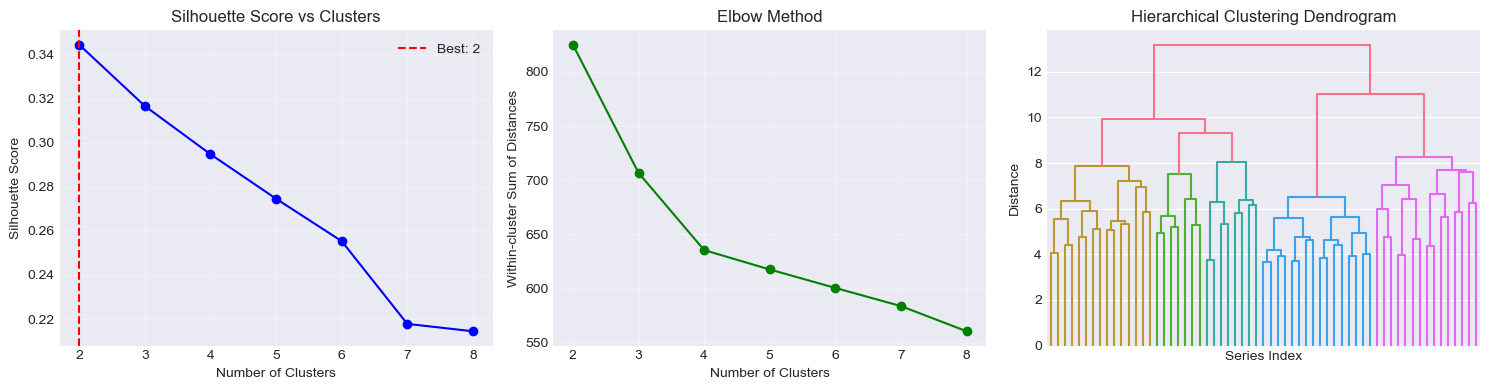


📊 CLUSTERING METRICS SUMMARY
Clusters:  2 | Silhouette:  0.344 | Inertia:   825.03
Clusters:  3 | Silhouette:  0.317 | Inertia:   706.77
Clusters:  4 | Silhouette:  0.295 | Inertia:   635.55
Clusters:  5 | Silhouette:  0.275 | Inertia:   617.66
Clusters:  6 | Silhouette:  0.255 | Inertia:   600.63
Clusters:  7 | Silhouette:  0.218 | Inertia:   583.89
Clusters:  8 | Silhouette:  0.214 | Inertia:   560.67
Recommended clusters (by Silhouette): 2


In [20]:
# ## Step 6: Optimal Number of Clusters Detection

# %%
def find_optimal_clusters(distance_matrix, max_clusters=30):
    """
    Find optimal number of clusters using multiple metrics
    """
    n_series = len(distance_matrix)
    max_clusters = min(max_clusters, n_series - 1)
    
    # Prepare for hierarchical clustering
    condensed_dist = squareform(distance_matrix)
    linkage_matrix = linkage(condensed_dist, method='average')
    
    # Calculate metrics for different cluster numbers
    silhouette_scores = []
    inertias = []
    
    cluster_range = range(2, max_clusters + 1)
    
    print("Evaluating different cluster numbers...")
    for n_clusters in tqdm(cluster_range, desc="Testing clusters"):
        # Get cluster assignments
        clusters = fcluster(linkage_matrix, n_clusters, criterion='maxclust')
        
        # Silhouette score
        if n_clusters < n_series:
            score = silhouette_score(distance_matrix, clusters, metric='precomputed')
            silhouette_scores.append(score)
        else:
            silhouette_scores.append(-1)
        
        # Within-cluster sum of distances (inertia)
        inertia = 0
        for c in range(1, n_clusters + 1):
            mask = clusters == c
            if np.sum(mask) > 1:
                cluster_distances = distance_matrix[mask][:, mask]
                inertia += np.sum(cluster_distances) / (2 * np.sum(mask))
        inertias.append(inertia)
    
    # Plot metrics
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # Silhouette scores
    axes[0].plot(cluster_range, silhouette_scores, 'bo-')
    axes[0].set_xlabel('Number of Clusters')
    axes[0].set_ylabel('Silhouette Score')
    axes[0].set_title('Silhouette Score vs Clusters')
    axes[0].grid(True, alpha=0.3)
    best_silhouette = np.argmax(silhouette_scores) + 2
    axes[0].axvline(x=best_silhouette, color='r', linestyle='--', 
                   label=f'Best: {best_silhouette}')
    axes[0].legend()
    
    # Elbow plot
    axes[1].plot(cluster_range, inertias, 'go-')
    axes[1].set_xlabel('Number of Clusters')
    axes[1].set_ylabel('Within-cluster Sum of Distances')
    axes[1].set_title('Elbow Method')
    axes[1].grid(True, alpha=0.3)
    
    # Dendrogram
    axes[2].set_title('Hierarchical Clustering Dendrogram')
    dendrogram(linkage_matrix, ax=axes[2], no_labels=True, 
              truncate_mode='level', p=5)
    axes[2].set_xlabel('Series Index')
    axes[2].set_ylabel('Distance')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n📊 CLUSTERING METRICS SUMMARY")
    print("="*50)
    for i, n in enumerate(cluster_range):
        print(f"Clusters: {n:2d} | Silhouette: {silhouette_scores[i]:6.3f} | "
              f"Inertia: {inertias[i]:8.2f}")
    print("="*50)
    print(f"Recommended clusters (by Silhouette): {best_silhouette}")
    
    return best_silhouette, linkage_matrix, silhouette_scores

# Find optimal clusters
optimal_k, linkage_mat, scores = find_optimal_clusters(dist_matrix, max_clusters=8)

In [16]:
# ## Step 7: Perform Clustering

# %%
def perform_clustering(distance_matrix, linkage_matrix, n_clusters):
    """
    Perform final clustering and analyze results
    """
    # Get cluster assignments
    clusters = fcluster(linkage_matrix, n_clusters, criterion='maxclust')
    
    # Calculate cluster statistics
    print(f"\n📊 CLUSTERING RESULTS (k={n_clusters})")
    print("="*50)
    
    cluster_sizes = {}
    for c in range(1, n_clusters + 1):
        size = np.sum(clusters == c)
        cluster_sizes[c] = size
        print(f"Cluster {c}: {size} series ({size/len(clusters)*100:.1f}%)")
    
    # Calculate cluster quality metrics
    silhouette = silhouette_score(distance_matrix, clusters, metric='precomputed')
    print(f"\nOverall Silhouette Score: {silhouette:.3f}")
    
    # Find medoids (most representative series) for each cluster
    medoids = {}
    for c in range(1, n_clusters + 1):
        mask = clusters == c
        if np.sum(mask) > 0:
            cluster_indices = np.where(mask)[0]
            # Find series with minimum distance to all others in cluster
            if len(cluster_indices) > 1:
                cluster_dist = distance_matrix[np.ix_(cluster_indices, cluster_indices)]
                medoid_idx = cluster_indices[np.argmin(np.sum(cluster_dist, axis=1))]
            else:
                medoid_idx = cluster_indices[0]
            medoids[c] = medoid_idx
            print(f"Cluster {c} medoid: Series {medoid_idx}")
    
    return clusters, medoids

# Perform clustering with optimal k
final_clusters, cluster_medoids = perform_clustering(dist_matrix, linkage_mat, optimal_k)


📊 CLUSTERING RESULTS (k=2)
Cluster 1: 102 series (51.0%)
Cluster 2: 98 series (49.0%)

Overall Silhouette Score: 0.344
Cluster 1 medoid: Series 146
Cluster 2 medoid: Series 134


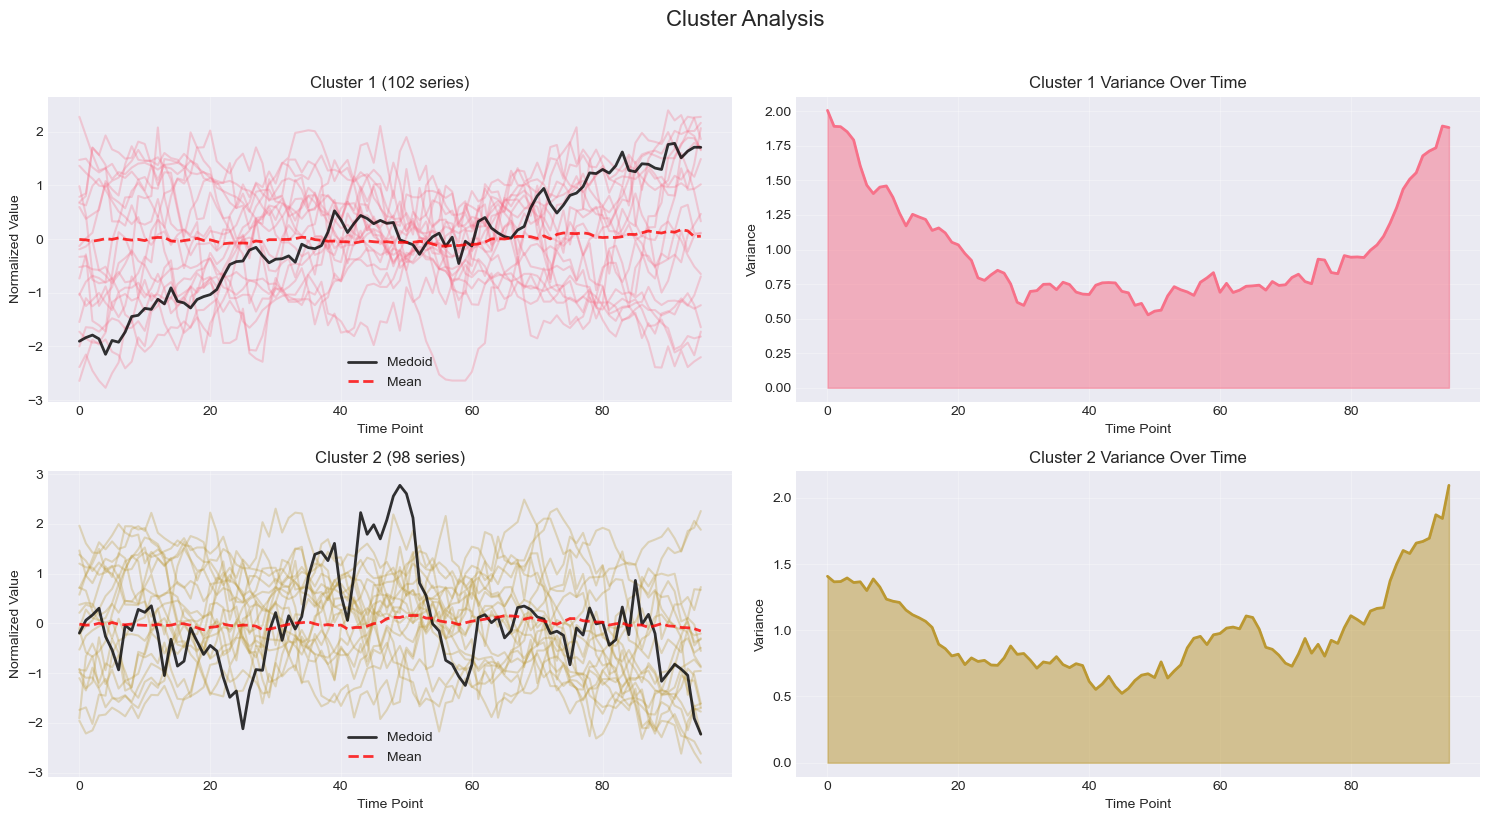

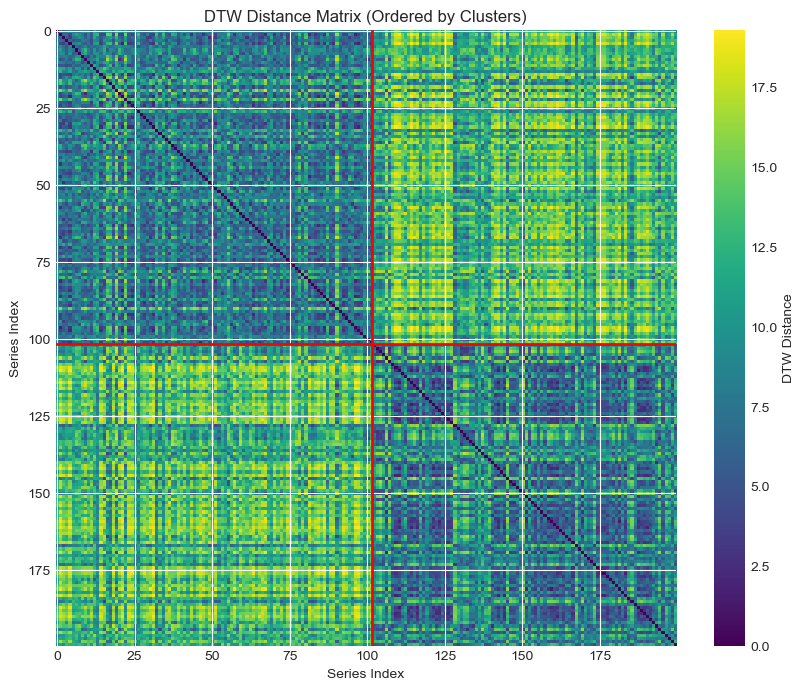

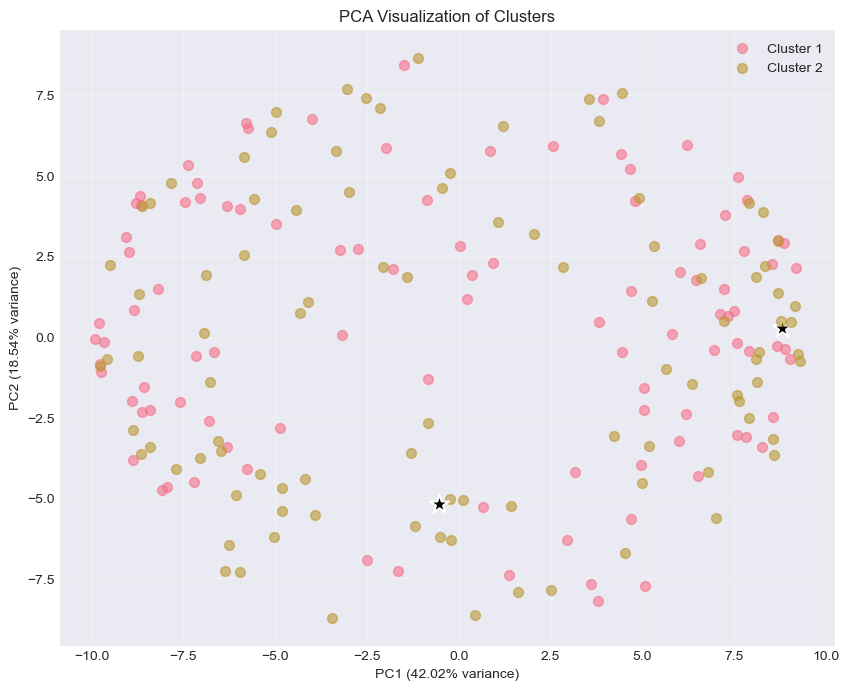

In [17]:
# ## Step 8: Visualize Clustering Results

# %%
def visualize_clusters(data, clusters, medoids, n_show_per_cluster=10):
    """
    Comprehensive visualization of clustering results
    """
    n_clusters = len(np.unique(clusters))
    
    # 1. Time series by cluster
    fig, axes = plt.subplots(n_clusters, 2, figsize=(15, 4*n_clusters))
    if n_clusters == 1:
        axes = axes.reshape(1, -1)
    
    for c in range(1, n_clusters + 1):
        mask = clusters == c
        cluster_data = data[mask]
        
        # Left: Show sample of series
        ax_left = axes[c-1, 0]
        n_show = min(n_show_per_cluster, len(cluster_data))
        for i in range(n_show):
            ax_left.plot(cluster_data[i], alpha=0.3, color=f'C{c-1}')
        
        # Plot medoid
        if c in medoids:
            medoid_series = data[medoids[c]]
            ax_left.plot(medoid_series, color='black', linewidth=2, 
                        label='Medoid', alpha=0.8)
        
        # Plot mean
        mean_series = np.mean(cluster_data, axis=0)
        ax_left.plot(mean_series, color='red', linewidth=2, 
                    label='Mean', linestyle='--', alpha=0.8)
        
        ax_left.set_title(f'Cluster {c} ({np.sum(mask)} series)')
        ax_left.set_xlabel('Time Point')
        ax_left.set_ylabel('Normalized Value')
        ax_left.legend()
        ax_left.grid(True, alpha=0.3)
        
        # Right: Show cluster statistics
        ax_right = axes[c-1, 1]
        
        # Variance over time
        variance = np.var(cluster_data, axis=0)
        ax_right.fill_between(range(len(variance)), variance, 
                             alpha=0.5, color=f'C{c-1}')
        ax_right.plot(variance, color=f'C{c-1}', linewidth=2)
        ax_right.set_title(f'Cluster {c} Variance Over Time')
        ax_right.set_xlabel('Time Point')
        ax_right.set_ylabel('Variance')
        ax_right.grid(True, alpha=0.3)
    
    plt.suptitle('Cluster Analysis', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()
    
    # 2. Distance matrix heatmap with cluster ordering
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    
    # Reorder distance matrix by clusters
    sorted_indices = np.argsort(clusters)
    sorted_dist_matrix = dist_matrix[sorted_indices][:, sorted_indices]
    sorted_clusters = clusters[sorted_indices]
    
    # Create cluster boundaries
    boundaries = [0]
    for c in range(1, n_clusters + 1):
        boundaries.append(boundaries[-1] + np.sum(clusters == c))
    
    # Plot heatmap
    im = ax.imshow(sorted_dist_matrix, cmap='viridis', aspect='auto')
    
    # Add cluster boundaries
    for b in boundaries[1:-1]:
        ax.axhline(y=b-0.5, color='red', linewidth=2)
        ax.axvline(x=b-0.5, color='red', linewidth=2)
    
    ax.set_title('DTW Distance Matrix (Ordered by Clusters)')
    ax.set_xlabel('Series Index')
    ax.set_ylabel('Series Index')
    plt.colorbar(im, ax=ax, label='DTW Distance')
    plt.show()
    
    # 3. PCA visualization
    if data.shape[0] > 2:
        pca = PCA(n_components=2)
        pca_result = pca.fit_transform(data)
        
        plt.figure(figsize=(10, 8))
        for c in range(1, n_clusters + 1):
            mask = clusters == c
            plt.scatter(pca_result[mask, 0], pca_result[mask, 1], 
                       label=f'Cluster {c}', alpha=0.6, s=50)
            
            # Mark medoid
            if c in medoids:
                plt.scatter(pca_result[medoids[c], 0], 
                          pca_result[medoids[c], 1],
                          color='black', marker='*', s=200, 
                          edgecolors='white', linewidths=1.5)
        
        plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
        plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
        plt.title('PCA Visualization of Clusters')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

# Visualize the results
visualize_clusters(normalized_data[:len(dist_matrix)], 
                  final_clusters, 
                  cluster_medoids, 
                  n_show_per_cluster=20)

In [18]:
# ## Step 9: Export Results

# %%
def export_clustering_results(original_df, clusters, medoids, filepath_prefix="cluster_results"):
    """
    Export clustering results to CSV files
    """
    # If we sampled, adjust the size
    n_clustered = len(clusters)
    
    # Create results dataframe
    results_df = pd.DataFrame({
        'series_index': range(n_clustered),
        'cluster': clusters,
        'is_medoid': [i in medoids.values() for i in range(n_clustered)]
    })
    
    # Add cluster statistics
    for c in range(1, max(clusters) + 1):
        mask = clusters == c
        results_df.loc[mask, 'cluster_size'] = np.sum(mask)
    
    # Save main results
    results_df.to_csv(f'{filepath_prefix}_assignments.csv', index=False)
    print(f"✓ Saved cluster assignments to {filepath_prefix}_assignments.csv")
    
    # Save medoid series
    medoid_data = []
    for c, idx in medoids.items():
        if idx < len(original_df):
            medoid_series = original_df.iloc[idx].values
            medoid_data.append([c, idx] + list(medoid_series))
    
    medoid_df = pd.DataFrame(medoid_data)
    medoid_df.columns = ['cluster', 'original_index'] + [f't_{i}' for i in range(len(medoid_series))]
    medoid_df.to_csv(f'{filepath_prefix}_medoids.csv', index=False)
    print(f"✓ Saved medoid series to {filepath_prefix}_medoids.csv")
    
    # Save summary statistics
    summary = []
    for c in range(1, max(clusters) + 1):
        summary.append({
            'cluster': c,
            'size': np.sum(clusters == c),
            'percentage': np.sum(clusters == c) / len(clusters) * 100,
            'medoid_index': medoids.get(c, -1)
        })
    
    summary_df = pd.DataFrame(summary)
    summary_df.to_csv(f'{filepath_prefix}_summary.csv', index=False)
    print(f"✓ Saved summary to {filepath_prefix}_summary.csv")
    
    return results_df, summary_df

# Export results
results, summary = export_clustering_results(df, final_clusters, cluster_medoids)

print("\n📊 FINAL SUMMARY")
print("="*50)
print(summary.to_string(index=False))

✓ Saved cluster assignments to cluster_results_assignments.csv
✓ Saved medoid series to cluster_results_medoids.csv
✓ Saved summary to cluster_results_summary.csv

📊 FINAL SUMMARY
 cluster  size  percentage  medoid_index
       1   102        51.0           146
       2    98        49.0           134


In [19]:
# %% [markdown]
# ## Step 10: Advanced Analysis - For Very Large Datasets (1000+ series)

# %%
def cluster_large_dataset_hierarchical(data, initial_clusters=50, final_clusters=5):
    """
    Two-stage clustering for very large datasets
    
    Stage 1: Cluster into many small clusters
    Stage 2: Cluster the medoids of Stage 1
    """
    n_series = len(data)
    print(f"Two-stage clustering for {n_series} series...")
    
    # Stage 1: Initial clustering with sampling
    print("\nStage 1: Initial clustering...")
    sample_size = min(500, n_series)
    sample_indices = np.random.choice(n_series, sample_size, replace=False)
    sample_data = data[sample_indices]
    
    # Compute distances for sample
    sample_dist = compute_dtw_matrix_parallel(sample_data, window_ratio=0.1)
    
    # Cluster sample
    condensed = squareform(sample_dist)
    linkage1 = linkage(condensed, method='average')
    clusters1 = fcluster(linkage1, initial_clusters, criterion='maxclust')
    
    # Find medoids for each initial cluster
    stage1_medoids = []
    for c in range(1, initial_clusters + 1):
        mask = clusters1 == c
        if np.sum(mask) > 0:
            cluster_indices = np.where(mask)[0]
            if len(cluster_indices) > 1:
                cluster_dist = sample_dist[np.ix_(cluster_indices, cluster_indices)]
                medoid_idx = cluster_indices[np.argmin(np.sum(cluster_dist, axis=1))]
            else:
                medoid_idx = cluster_indices[0]
            stage1_medoids.append(sample_data[medoid_idx])
    
    print(f"Stage 1 complete: {len(stage1_medoids)} medoids identified")
    
    # Stage 2: Cluster the medoids
    print("\nStage 2: Clustering medoids...")
    medoid_array = np.array(stage1_medoids)
    medoid_dist = compute_dtw_matrix_parallel(medoid_array, window_ratio=0.15)
    
    # Final clustering
    condensed2 = squareform(medoid_dist)
    linkage2 = linkage(condensed2, method='average')
    final_clusters = fcluster(linkage2, final_clusters, criterion='maxclust')
    
    print(f"✓ Two-stage clustering complete")
    print(f"Final clusters: {final_clusters}")
    
    # Assign all original series to nearest medoid cluster
    print("\nAssigning all series to final clusters...")
    all_clusters = np.zeros(n_series)
    
    # For non-sampled series, find nearest medoid
    for i in tqdm(range(n_series), desc="Assigning series"):
        if i not in sample_indices:
            # Find nearest medoid
            min_dist = float('inf')
            best_cluster = 1
            for j, medoid in enumerate(stage1_medoids):
                dist = dtw.distance_fast(data[i], medoid, window=10, use_pruning=True)
                if dist < min_dist:
                    min_dist = dist
                    best_cluster = final_clusters[j]
            all_clusters[i] = best_cluster
        else:
            # For sampled series, use their cluster assignment
            sample_idx = np.where(sample_indices == i)[0][0]
            initial_cluster = clusters1[sample_idx]
            if initial_cluster <= len(final_clusters):
                all_clusters[i] = final_clusters[initial_cluster - 1]
    
    return all_clusters

# Only run this for very large datasets
if len(normalized_data) > 500:
    print("Dataset is large. Using two-stage clustering...")
    large_clusters = cluster_large_dataset_hierarchical(
        normalized_data, 
        initial_clusters=20, 
        final_clusters=optimal_k
    )
    print(f"Large dataset clustering complete!")
else:
    print("Dataset size is manageable. Using standard clustering.")

# %% [markdown]
# ## Bonus: Quick Function for New Data

# %%
def quick_cluster_analysis(filepath, n_clusters=None, max_series=200):
    """
    All-in-one function for quick clustering analysis
    """
    # Load
    df = pd.read_csv(filepath)
    data = df.values
    
    # Sample if too large
    if len(data) > max_series:
        print(f"Sampling {max_series} from {len(data)} series...")
        indices = np.random.choice(len(data), max_series, replace=False)
        data = data[indices]
    
    # Normalize
    normalized = np.array([(row - row.mean()) / row.std() for row in data])
    
    # Compute distances
    print("Computing DTW distances...")
    dist_matrix = compute_dtw_matrix_parallel(normalized, window_ratio=0.1)
    
    # Cluster
    condensed = squareform(dist_matrix)
    Z = linkage(condensed, method='average')
    
    if n_clusters is None:
        # Auto-detect optimal clusters
        scores = []
        for k in range(2, min(8, len(data))):
            clusters = fcluster(Z, k, criterion='maxclust')
            score = silhouette_score(dist_matrix, clusters, metric='precomputed')
            scores.append(score)
        n_clusters = np.argmax(scores) + 2
        print(f"Optimal clusters detected: {n_clusters}")
    
    clusters = fcluster(Z, n_clusters, criterion='maxclust')
    
    # Results
    print("\nClustering Results:")
    for c in range(1, n_clusters + 1):
        size = np.sum(clusters == c)
        print(f"  Cluster {c}: {size} series ({size/len(clusters)*100:.1f}%)")
    
    score = silhouette_score(dist_matrix, clusters, metric='precomputed')
    print(f"\nSilhouette Score: {score:.3f}")
    
    return clusters, dist_matrix, normalized

# Example usage:
# results = quick_cluster_analysis("your_data.csv", n

Dataset is large. Using two-stage clustering...
Two-stage clustering for 3103 series...

Stage 1: Initial clustering...
Computing DTW distances for 500 series...
Series length: 96
Window size: 9
Total comparisons: 124,750


DTW Batches: 100%|███████████████████████████████████████████████████████████████████| 125/125 [00:02<00:00, 43.15it/s]


✓ Distance computation complete in 2.90 seconds
Average time per comparison: 0.0000 seconds
Stage 1 complete: 20 medoids identified

Stage 2: Clustering medoids...
Computing DTW distances for 20 series...
Series length: 96
Window size: 14
Total comparisons: 190


Computing DTW: 100%|██████████████████████████████████████████████████████████████| 190/190 [00:00<00:00, 31283.57it/s]


✓ Distance computation complete in 0.01 seconds
Average time per comparison: 0.0001 seconds
✓ Two-stage clustering complete
Final clusters: [1 1 1 1 1 1 2 1 1 1 1 2 2 2 1 1 2 2 2 1]

Assigning all series to final clusters...


Assigning series: 100%|██████████████████████████████████████████████████████████| 3103/3103 [00:01<00:00, 2348.82it/s]

Large dataset clustering complete!
